## Group 1 - Phase 2
### (Models - Logistic Regression, Random Forest Classifier, Decision Tree Classifier)

In [42]:
import numpy as np
import pandas as pd
from pandas import DataFrame
from matplotlib import pyplot as plt 
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re
from string import punctuation
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score,roc_auc_score,\
accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
import seaborn as sns


from numpy import array
import warnings
warnings.filterwarnings('ignore')

import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/suvijain/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/suvijain/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Loading datasets for Eclipse, Mozilla, Thunderbird and combining to form 3 different dataframes

In [2]:
# Loading all the given datasets in 6 dataframes

df1 = pd.read_csv('EP_nondup.csv',sep=';')
df2 = pd.read_csv('EP_dup.csv',sep=';')
df3 = pd.read_csv('M_Duplicate BRs.csv',sep=';')
df4 = pd.read_csv('M_NonDuplicate BRs.csv',sep=';')
df5 = pd.read_csv('dup_TB.csv',sep=';')
df6 = pd.read_csv('Nondup_TB.csv',sep=';')

frames_ecl = [df1,df2]
frames_moz = [df3,df4]
frames_tb = [df5,df6]

# Concatenating 2 datasets for each of the platforms to form 3 datasets
df_ecl = pd.concat(frames_ecl)
df_moz = pd.concat(frames_moz)
df_tb = pd.concat(frames_tb)

In [3]:
print(len(df_ecl)+len(df_moz)+len(df_tb))

122075


In [4]:
df2

,Issue_id,Duplicated_issue,Title1,Description1,Title2,Description2,Label
0,25,28126,cvs ui need vcm prefs default repo connection gc,it would be helpful if there was a notion of d...,wizards patch standard public cvs repositories,this patch adds a convenient way to check thin...,1
1,40,20,need connect to team stream gcqpkw,i would like to be able to connect to a team s...,workspace files,thought it would be useful if the set of repo ...,1
2,48,22,make sure can future store other project refer...,project references come in three flavours . p...,persist sharing recommendations and project ve...,project descriptions dont store sharing recomm...,1
3,61,60,.vcmmeta showing as change gdqtgw,useruser install drop into declipse user ...,need custom .vcmignore comparemerge gdqt,useruser install drop into declipse user ...,1
4,94,2,repositories view all file types open to the t...,when browsing files in the repositories view i...,opening repository resources doesnt honor type...,opening repository resource open the default ...,1
...,...,...,...,...,...,...,...
12681,423034,287720,.metadata.log error,please see my .log file please fix this error,eclipse crashes while startup,id .. .eclipse crashes on startup . . more...,1
12682,423852,422971,workbench classcastexception handlerprocessing...,backport into .. this bug was initially crea...,workbench classcastexception handlerprocessing...,backport to .. this bug was initially create...,1
12683,423888,413977,keybindings resizing content assist proposal p...,tested on newly installed standard kepler sr o...,keybindings all nonnative key bindings stop wo...,. and latest n. . paste the following snippet...,1
12684,424120,418254,close window from context menu,context menu eclipse.id...m java.version.. ja...,editormgmt keybindings ctrle and delete causes...,after updating my kepler eclipse .. to service...,1


In [5]:
print("Eclipse dataset shape: ",df_ecl.shape)
print("Mozilla dataset shape: ",df_moz.shape)
print("Thunderbird dataset shape: ",df_tb.shape)

Eclipse dataset shape:  (46908, 7)
Mozilla dataset shape:  (60904, 7)
Thunderbird dataset shape:  (14263, 7)


In [6]:
# Counting the unique values in label for the 3 datasets
print(df_ecl['Label'].value_counts())
print(df_moz['Label'].value_counts())
print(df_tb['Label'].value_counts())

0    34222
1    12686
Name: Label, dtype: int64
0    36833
1    24071
Name: Label, dtype: int64
0    9905
1    4358
Name: Label, dtype: int64


### Combining the text in Title and description column for all datasets in order to vectorize them together

In [7]:
df_ecl['Bug1'] = df_ecl['Title1'].str.cat(df_ecl['Description1'],sep=" ")
df_ecl['Bug2'] = df_ecl['Title2'].str.cat(df_ecl['Description2'],sep=" ")

df_moz['Bug1'] = df_moz['Title1'].str.cat(df_moz['Description1'],sep=" ")
df_moz['Bug2'] = df_moz['Title2'].str.cat(df_moz['Description2'],sep=" ")

df_tb['Bug1'] = df_tb['Title1'].str.cat(df_tb['Description1'],sep=" ")
df_tb['Bug2'] = df_tb['Title2'].str.cat(df_tb['Description2'],sep=" ")
df_ecl.Bug1

0        usability issue with external editors geirl se...
1        opening repository resources doesnt honor type...
2        sync does not indicate deletion gien kmpm \tth...
3        need better error message if catching up over ...
4        isharingmanager sharing api inconsistent gaulh...
                               ...                        
12681    .metadata.log error please see my .log file  p...
12682    workbench classcastexception handlerprocessing...
12683    keybindings resizing content assist proposal p...
12684    close window from context menu context menu  e...
12685    viewmgmt findviewreference always returns null...
Name: Bug1, Length: 46908, dtype: object

### Remove puncctuations and stop words from the datasets to process

In [8]:
stop_words = set(stopwords.words('english'))

def words(text):
    text = ''.join([i for i in text if i not in punctuation])
    text = text.lower()
    text = text.split()
    text = [j for j in text if not j in stop_words]
    text = " ".join(text)
    return(text)

In [9]:
def preprocess(bug_reports,bugs_all):
    for n in bugs_all:
        bug_reports.append(words(n))

In [10]:
bug_pp_ecl1 = []
bug_pp_ecl2 = []

bug_pp_moz1 = []
bug_pp_moz2 = []

bug_pp_tb1 = []
bug_pp_tb2 = []

preprocess(bug_pp_ecl1, df_ecl.Bug1)
preprocess(bug_pp_ecl2, df_ecl.Bug2)

preprocess(bug_pp_moz1, df_moz.Bug1)
preprocess(bug_pp_moz2, df_moz.Bug2)

preprocess(bug_pp_tb1, df_tb.Bug1)
preprocess(bug_pp_tb2, df_tb.Bug2)

### Define TFIDF veectorizer

In [11]:
tfidf_ecl = TfidfVectorizer(analyzer = 'word',stop_words = 'english',lowercase = True,max_features = 700,norm = 'l2')
tfidf_moz = TfidfVectorizer(analyzer = 'word',stop_words = 'english',lowercase = True,max_features = 700,norm = 'l2')
tfidf_tb = TfidfVectorizer(analyzer = 'word',stop_words = 'english',lowercase = True,max_features = 700,norm = 'l2')

In [12]:
words_ecl = pd.concat([df_ecl.Bug1,df_ecl.Bug2], axis = 0)
words_moz = pd.concat([df_moz.Bug1,df_moz.Bug2], axis = 0)
words_tb = pd.concat([df_tb.Bug1,df_tb.Bug2], axis = 0)

In [13]:
tfidf_ecl.fit(words_ecl)
tfidf_moz.fit(words_moz)
tfidf_tb.fit(words_tb)

duplicate_ecl_1 = tfidf_ecl.transform(df_ecl.Bug1)
duplicate_ecl_2 = tfidf_ecl.transform(df_ecl.Bug2)

duplicate_moz_1 = tfidf_moz.transform(df_moz.Bug1)
duplicate_moz_2 = tfidf_moz.transform(df_moz.Bug2)

duplicate_tb_1 = tfidf_tb.transform(df_tb.Bug1)
duplicate_tb_2 = tfidf_tb.transform(df_tb.Bug2)

In [14]:
x_ecl = abs(duplicate_ecl_1 - duplicate_ecl_2)
y_ecl = df_ecl['Label']

x_moz = abs(duplicate_moz_1 - duplicate_moz_2)
y_moz = df_moz['Label']

x_tb = abs(duplicate_tb_1 - duplicate_tb_2)
y_tb = df_tb['Label']

In [19]:
x_ecl_train, x_ecl_test, y_ecl_train, y_ecl_test = train_test_split(x_ecl, y_ecl, test_size=0.3)

x_moz_train, x_moz_test, y_moz_train, y_moz_test = train_test_split(x_moz, y_moz, test_size=0.3)

x_tb_train, x_tb_test, y_tb_train, y_tb_test = train_test_split(x_tb, y_tb, test_size=0.3)

## Logistic Regression

In [20]:
lr_ecl = LogisticRegression(max_iter=1000)
lr_ecl.fit(x_ecl_train, y_ecl_train)

lr_moz = LogisticRegression(max_iter=1000)
lr_moz.fit(x_moz_train, y_moz_train)

lr_tb = LogisticRegression(max_iter=1000)
lr_tb.fit(x_tb_train, y_tb_train)

LogisticRegression(max_iter=1000)

In [38]:
y_pred_ecl = lr_ecl.predict(x_ecl_test) 
y_pred_moz = lr_moz.predict(x_moz_test) 
y_pred_tb = lr_tb.predict(x_tb_test)

lr_ecl_auc = roc_auc_score(y_ecl, lr_ecl.predict_proba(x_ecl)[:, 1])
lr_moz_auc = roc_auc_score(y_moz, lr_moz.predict_proba(x_moz)[:, 1])
lr_tb_auc = roc_auc_score(y_tb, lr_tb.predict_proba(x_tb)[:, 1])

lr_ecl_acc = accuracy_score(y_ecl_test, y_pred_ecl)
lr_moz_acc = accuracy_score(y_moz_test, y_pred_moz)
lr_tb_acc = accuracy_score(y_tb_test, y_pred_tb)

lr_ecl_prec = precision_score(y_ecl_test, y_pred_ecl)
lr_moz_prec = precision_score(y_moz_test, y_pred_moz)
lr_tb_prec = precision_score(y_tb_test, y_pred_tb)

lr_ecl_recall = recall_score(y_ecl_test, y_pred_ecl)
lr_moz_recall = recall_score(y_moz_test, y_pred_moz)
lr_tb_recall = recall_score(y_tb_test, y_pred_tb)

In [22]:
def print_evalreport(y_test,y_pred):
    confmatrix = confusion_matrix(y_test,y_pred)
    TP = confmatrix[1][1]
    TN = confmatrix[0][0]
    FP = confmatrix[1][0]
    FN = confmatrix[0][1]
    accuracy = (TP + TN)/(TP + TN + FP + FN)
    print("\nTrue Positive  : ", TP)
    print("True Negative  : ", TN)
    print("False Positive : ", FP)
    print("False Negative : ", FN)
    print("Accuracy       : ",accuracy)

print_evalreport(y_ecl_test,y_pred_ecl)
print_evalreport(y_moz_test,y_pred_moz)
print_evalreport(y_tb_test,y_pred_tb)

target_names = ['Non Duplicate', 'Duplicate']
print(classification_report(y_ecl_test, y_pred_ecl, target_names=target_names))
print(classification_report(y_moz_test, y_pred_moz, target_names=target_names))
print(classification_report(y_tb_test, y_pred_tb, target_names=target_names))


True Positive  :  1957
True Negative  :  9607
False Positive :  1838
False Negative :  671
Accuracy       :  0.8217153414339515

True Positive  :  5037
True Negative  :  9425
False Positive :  2239
False Negative :  1571
Accuracy       :  0.791484238178634

True Positive  :  837
True Negative  :  2711
False Positive :  501
False Negative :  230
Accuracy       :  0.8291656929189063
               precision    recall  f1-score   support

Non Duplicate       0.84      0.93      0.88     10278
    Duplicate       0.74      0.52      0.61      3795

     accuracy                           0.82     14073
    macro avg       0.79      0.73      0.75     14073
 weighted avg       0.81      0.82      0.81     14073

               precision    recall  f1-score   support

Non Duplicate       0.81      0.86      0.83     10996
    Duplicate       0.76      0.69      0.73      7276

     accuracy                           0.79     18272
    macro avg       0.79      0.77      0.78     18272
 weig

### Random Forest Classifier

In [23]:
rf_ecl = RandomForestClassifier(max_depth=20)
rf_ecl.fit(x_ecl_train, y_ecl_train)

rf_moz = RandomForestClassifier(max_depth=20)
rf_moz.fit(x_moz_train, y_moz_train)

rf_tb = RandomForestClassifier(max_depth=20)
rf_tb.fit(x_tb_train, y_tb_train)

RandomForestClassifier(max_depth=20)

In [39]:
y_pred_ecl = rf_ecl.predict(x_ecl_test) 
y_pred_moz = rf_moz.predict(x_moz_test) 
y_pred_tb = rf_tb.predict(x_tb_test)


dt_ecl_auc = roc_auc_score(y_ecl, dt_ecl.predict_proba(x_ecl)[:, 1])
dt_moz_auc = roc_auc_score(y_moz, dt_moz.predict_proba(x_moz)[:, 1])
dt_tb_auc = roc_auc_score(y_tb, dt_tb.predict_proba(x_tb)[:, 1])

dt_ecl_acc = accuracy_score(y_ecl_test, y_pred_ecl)
dt_moz_acc = accuracy_score(y_moz_test, y_pred_moz)
dt_tb_acc = accuracy_score(y_tb_test, y_pred_tb)

dt_ecl_prec = precision_score(y_ecl_test, y_pred_ecl)
dt_moz_prec = precision_score(y_moz_test, y_pred_moz)
dt_tb_prec = precision_score(y_tb_test, y_pred_tb)

dt_ecl_recall = recall_score(y_ecl_test, y_pred_ecl)
dt_moz_recall = recall_score(y_moz_test, y_pred_moz)
dt_tb_recall = recall_score(y_tb_test, y_pred_tb)

In [25]:
print_evalreport(y_ecl_test,y_pred_ecl)
print_evalreport(y_moz_test,y_pred_moz)
print_evalreport(y_tb_test,y_pred_tb)

print(classification_report(y_ecl_test, y_pred_ecl, target_names=target_names))
print(classification_report(y_moz_test, y_pred_moz, target_names=target_names))
print(classification_report(y_tb_test, y_pred_tb, target_names=target_names))


True Positive  :  345
True Negative  :  10253
False Positive :  3450
False Negative :  25
Accuracy       :  0.7530732608541179

True Positive  :  3087
True Negative  :  10304
False Positive :  4189
False Negative :  692
Accuracy       :  0.7328699649737302

True Positive  :  313
True Negative  :  2921
False Positive :  1025
False Negative :  20
Accuracy       :  0.7557840616966581
               precision    recall  f1-score   support

Non Duplicate       0.75      1.00      0.86     10278
    Duplicate       0.93      0.09      0.17      3795

     accuracy                           0.75     14073
    macro avg       0.84      0.54      0.51     14073
 weighted avg       0.80      0.75      0.67     14073

               precision    recall  f1-score   support

Non Duplicate       0.71      0.94      0.81     10996
    Duplicate       0.82      0.42      0.56      7276

     accuracy                           0.73     18272
    macro avg       0.76      0.68      0.68     18272
 weig

### Decision Tree Classifier

In [26]:
dt_ecl = tree.DecisionTreeClassifier()
dt_ecl = dt_ecl.fit(x_ecl_train, y_ecl_train)

dt_moz = tree.DecisionTreeClassifier()
dt_moz = dt_moz.fit(x_moz_train, y_moz_train)

dt_tb = tree.DecisionTreeClassifier()
dt_tb = dt_tb.fit(x_tb_train, y_tb_train)

In [40]:
y_pred_ecl = dt_ecl.predict(x_ecl_test) 
y_pred_moz = dt_moz.predict(x_moz_test) 
y_pred_tb = dt_tb.predict(x_tb_test)


rf_ecl_auc = roc_auc_score(y_ecl, rf_ecl.predict_proba(x_ecl)[:, 1])
rf_moz_auc = roc_auc_score(y_moz, rf_moz.predict_proba(x_moz)[:, 1])
rf_tb_auc = roc_auc_score(y_tb, rf_tb.predict_proba(x_tb)[:, 1])

rf_ecl_acc = accuracy_score(y_ecl_test, y_pred_ecl)
rf_moz_acc = accuracy_score(y_moz_test, y_pred_moz)
rf_tb_acc = accuracy_score(y_tb_test, y_pred_tb)

rf_ecl_prec = precision_score(y_ecl_test, y_pred_ecl)
rf_moz_prec = precision_score(y_moz_test, y_pred_moz)
rf_tb_prec = precision_score(y_tb_test, y_pred_tb)

rf_ecl_recall = recall_score(y_ecl_test, y_pred_ecl)
rf_moz_recall = recall_score(y_moz_test, y_pred_moz)
rf_tb_recall = recall_score(y_tb_test, y_pred_tb)

In [28]:
print_evalreport(y_ecl_test,y_pred_ecl)
print_evalreport(y_moz_test,y_pred_moz)
print_evalreport(y_tb_test,y_pred_tb)

print(classification_report(y_ecl_test, y_pred_ecl, target_names=target_names))
print(classification_report(y_moz_test, y_pred_moz, target_names=target_names))
print(classification_report(y_tb_test, y_pred_tb, target_names=target_names))


True Positive  :  1755
True Negative  :  8070
False Positive :  2040
False Negative :  2208
Accuracy       :  0.6981453847793647

True Positive  :  4236
True Negative  :  7718
False Positive :  3040
False Negative :  3278
Accuracy       :  0.6542250437828371

True Positive  :  665
True Negative  :  2271
False Positive :  673
False Negative :  670
Accuracy       :  0.6861416218742696
               precision    recall  f1-score   support

Non Duplicate       0.80      0.79      0.79     10278
    Duplicate       0.44      0.46      0.45      3795

     accuracy                           0.70     14073
    macro avg       0.62      0.62      0.62     14073
 weighted avg       0.70      0.70      0.70     14073

               precision    recall  f1-score   support

Non Duplicate       0.72      0.70      0.71     10996
    Duplicate       0.56      0.58      0.57      7276

     accuracy                           0.65     18272
    macro avg       0.64      0.64      0.64     18272
 we

In [47]:
df_results = pd.DataFrame({'classifier':['LR','LR','LR','DT','DT','DT','RF','RF','RF'],
                           'dataset_used':['eclipse','mozilla','thunderbird']*3,
                          'auc':[lr_ecl_auc,lr_moz_auc,lr_tb_auc,dt_ecl_auc,dt_moz_auc,dt_tb_auc,\
                                     rf_ecl_auc,rf_moz_auc,rf_tb_auc],
                          'accuracy':[lr_ecl_acc,lr_moz_acc,lr_tb_acc,dt_ecl_acc,dt_moz_acc,dt_tb_acc,\
                                     rf_ecl_acc,rf_moz_acc,rf_tb_acc],
                          'recall':[lr_ecl_recall,lr_moz_recall,lr_tb_recall,dt_ecl_recall,dt_moz_recall,dt_tb_recall,\
                                     rf_ecl_recall,rf_moz_recall,rf_tb_recall],
                          'precision':[lr_ecl_prec,lr_moz_prec,lr_tb_prec,dt_ecl_prec,dt_moz_prec,dt_tb_prec,\
                                     rf_ecl_prec,rf_moz_prec,rf_tb_prec]})
df_results

,classifier,dataset_used,auc,accuracy,recall,precision
0,LR,eclipse,0.861728,0.821715,0.515679,0.744673
1,LR,mozilla,0.869683,0.791484,0.692276,0.762258
2,LR,thunderbird,0.899117,0.829166,0.625561,0.784442
3,DT,eclipse,0.887336,0.753073,0.090909,0.932432
4,DT,mozilla,0.892355,0.732870,0.424272,0.816883
5,DT,thunderbird,0.888964,0.755784,0.233931,0.939940
6,RF,eclipse,0.935200,0.698145,0.462451,0.442846
7,RF,mozilla,0.933971,0.654225,0.582188,0.563748
8,RF,thunderbird,0.960885,0.686142,0.497010,0.498127


MODEL PERFORMANCE METRICS


<function matplotlib.pyplot.show(close=None, block=None)>

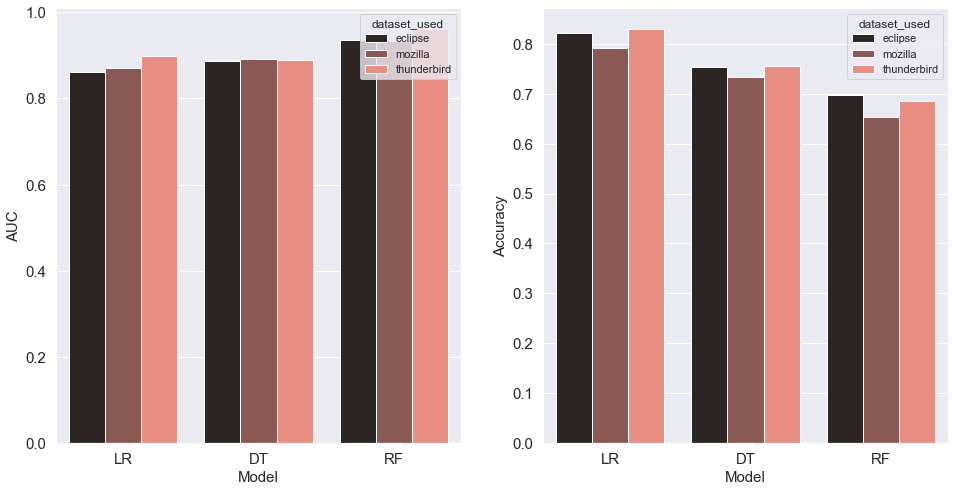

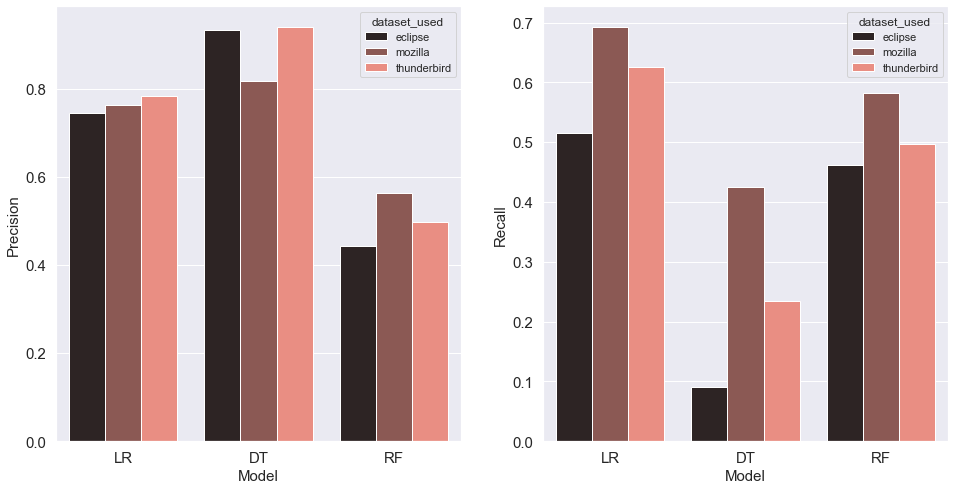

In [48]:
print("MODEL PERFORMANCE METRICS")

sns.set(style="darkgrid")

fig, axs = plt.subplots(ncols=2)
sns.set(rc={'figure.figsize':(16,8)})
ax = sns.barplot(x="classifier", y="auc", hue="dataset_used", data=df_results,ax=axs[0],palette="dark:salmon")
ax.set_xlabel('Model',fontsize = 15)
ax.set_ylabel('AUC', fontsize = 15)
ax.tick_params(labelsize=15)

sns.set(rc={'figure.figsize':(16,8)})
ax = sns.barplot(x="classifier", y="accuracy", hue="dataset_used", data=df_results,ax=axs[1],palette="dark:salmon")
ax.set_xlabel('Model',fontsize = 15)
ax.set_ylabel('Accuracy', fontsize = 15)
ax.tick_params(labelsize=15)

fig, axs = plt.subplots(ncols=2)
sns.set(rc={'figure.figsize':(16,8)})
ax = sns.barplot(x="classifier", y="precision", hue="dataset_used", data=df_results,ax=axs[0],palette="dark:salmon")
ax.set_xlabel('Model',fontsize = 15)
ax.set_ylabel('Precision', fontsize = 15)
ax.tick_params(labelsize=15)

sns.set(rc={'figure.figsize':(16,8)})
ax = sns.barplot(x="classifier", y="recall", hue="dataset_used", data=df_results,ax=axs[1],palette="dark:salmon")
ax.set_xlabel('Model',fontsize = 15)
ax.set_ylabel('Recall', fontsize = 15)
ax.tick_params(labelsize=15)
plt.show